1. Четыре основные когорты: Android, iOS, органика, неорганика; и два основных региона:
CIS и NA.
2. Строим график LTV каждой когорты (через CARPU) и каждого региона. Определяем
номинальную точку LTV (точку после которой LTV практически не растет)
3. Считаем LifeTime (через сумму дневных Rolling retention) и ARPDAU каждой когорты,
каждого региона. Вычисляем LTV через умножая LifeTime на ARPDAU.
4. Считаем LifeTime (через сумму дневных Retention Rate) и ARPDAU каждой когорты,
каждого региона. Вычисляем LTV через умножая LifeTime на ARPDAU.
5. Сравниваем показатели LTV в пунктах 2, 3 и 4. Делаем вывод какой из методов более
практичный.
p.s. Все расчёты делать в долларах USA.

In [2]:
#расчет CARPU для пункта 2
CARPU=pd.read_sql(f'''
with data as
     (SELECT  event_time, user_id, platform, 
        min(event_time) filter (where event_name='FirstLaunchApp') OVER(PARTITION BY user_id) as date_install,
        case WHEN country in ('RU', 'AZ', 'AM', 'BY','KZ', 'KG','MD', 'TJ', 'UZ', 'UA', 'TM') then 'CIS'
             WHEN country in ('CA', 'US') then 'NA'
             else 'Other' 
                         end as region,
        user_type,revenue_usd     
        FROM data_viz_1068.project_dataset
        WHERE user_id in
                (SELECT user_id
                FROM data_viz_1068.project_dataset
                WHERE event_name='FirstLaunchApp'))
     

SELECT lifetime,platform,region,user_type,rev, с_rev_usd/users as CARPU
FROM
(SELECT lifetime,platform,region,user_type,rev,
sum(rev) OVER(PARTITION BY platform, region,user_type ORDER BY  lifetime ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS с_rev_usd,
max(users) OVER(PARTITION BY platform, region,user_type ORDER BY  lifetime) as users

FROM
        (SELECT lifetime, platform, region,user_type,count(distinct user_id) as users,sum(rev_usd) as rev
        FROM
            (SELECT max(extract(day from date_trunc('days',event_time-date_install))) as lifetime,
            user_id, platform, region,user_type,sum(revenue_usd) as rev_usd
            FROM data
            GROUP BY 2,3,4,5) as l
        WHERE lifetime between '0' and '90' and region!='Other' 
        GROUP BY 1,2,3,4) as q

ORDER BY  lifetime, platform, region,user_type) as g
''', con=engine)

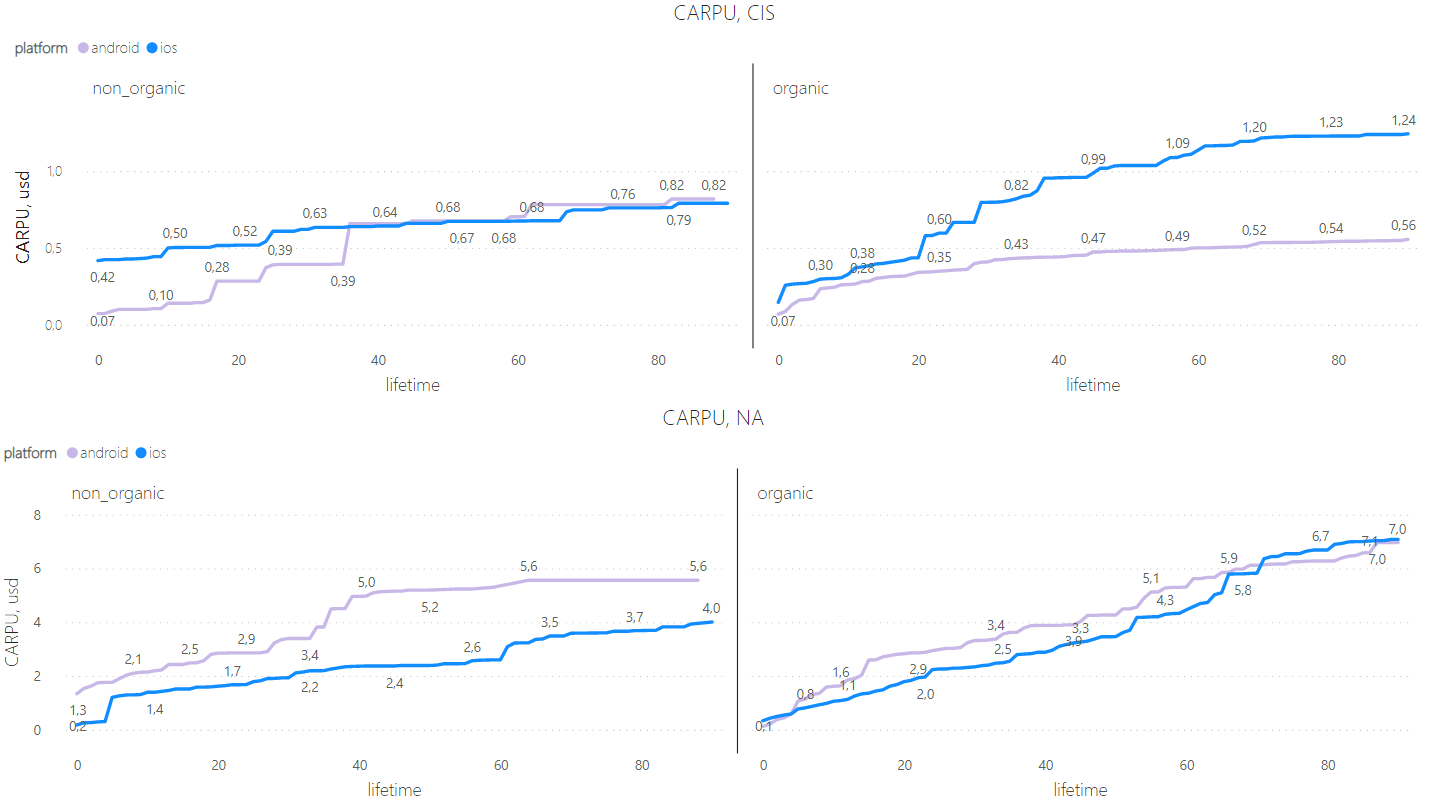


Номинальные точки:
1. Неорганический трафик:

    CIS, androind - примерно 38 день жизни пользователя, LTV - 0,62$
    
    CIS, ios - 23 день жизни пользователя, LTV - 0,6$
    
    NA, anroid - 39 день жизни пользователя, LTV - 4,7$
    
    NA, ios - 60 день жизни пользователя, LTV - 2,8$
    
    
2. Органический трафик:

     CIS, androind - от 5 до 20 дня, но именно до 5 дня самый большой скачок в росте LTV, показатель - 0,28$
     
     CIS, ios - заметный рост уменьшается после 42 дня, LTV - ~1$
     
     NA, anroid - стабильный рост до 64 дня, LTV - 5,9$
    
     NA, ios - ~60 день, LTV - 6,1$
    
    

In [3]:
#1 вариант расчет к пункту 3 (c днями после установки), arpdau расчитывалось как cum.rev/cum.dau, lifetime - cum.roll.ret
ex3=pd.read_sql(f'''
with all_data as
(with data as

         (SELECT  event_time, user_id, platform, 
            min(event_time) filter (where event_name='FirstLaunchApp') OVER(PARTITION BY user_id) as date_install,
            case WHEN country in ('RU', 'AZ', 'AM', 'BY','KZ', 'KG','MD', 'TJ', 'UZ', 'UA', 'TM') then 'CIS'
                 WHEN country in ('CA', 'US') then 'NA' else 'Other' end as region,
            user_type,revenue_usd

            FROM data_viz_1068.project_dataset
            WHERE user_id in
                    (SELECT user_id
                    FROM data_viz_1068.project_dataset
                    WHERE event_name='FirstLaunchApp')),

    temp_df as(
        SELECT case when user_id>0 then '1' end as  merge,(ROW_NUMBER() OVER())-1 num
        FROM data_viz_1068.project_dataset
        WHERE event_name='FirstLaunchApp'
        LIMIT 91
    )

        SELECT lifetime, cast(users as float)/cast(max as float) as ret_roll, platform, region,user_type,c_dau,
        sum(rev) OVER(PARTITION BY platform, region,user_type ORDER BY  lifetime ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS с_rev_usd
        FROM
            (SELECT num as lifetime, count(distinct user_id) as users,platform, region,user_type,
            max(count(distinct user_id)) over (partition by platform, region,user_type) as max, sum(rev) as rev,
            sum(count(distinct user_id)) OVER(PARTITION BY platform, region,user_type ORDER BY  num ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS c_dau

            FROM
            (SELECT lifetime,num, user_id,platform, region,user_type,rev
            FROM
                    (SELECT *
                    FROM (SELECT max(extract(day from date_trunc('days',event_time-date_install))) as lifetime,
                    user_id, platform, region,user_type, case when user_id>0 then '1' end as  merge,sum(revenue_usd) as rev
                    FROM data
                    WHERE event_time <=(date_install+INTERVAL '3' MONTH) and region !='Other'
                    GROUP BY 2,3,4,5
                    ORDER BY 1) as l

                    JOIN temp_df  as i
                    ON l.merge=i.merge) as o
            WHERE lifetime>=num 
            ) as f
            GROUP BY 1,3,4,5) as w)
            
SELECT lifetime,platform, region,user_type,arpdau*sum_roll as ltv
FROM
    (SELECT lifetime, platform, region,user_type, (с_rev_usd/c_dau) as arpdau,
    sum(ret_roll) OVER(PARTITION BY platform, region,user_type ORDER BY  lifetime ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS sum_roll
    FROM all_data) as e


''', con=engine)

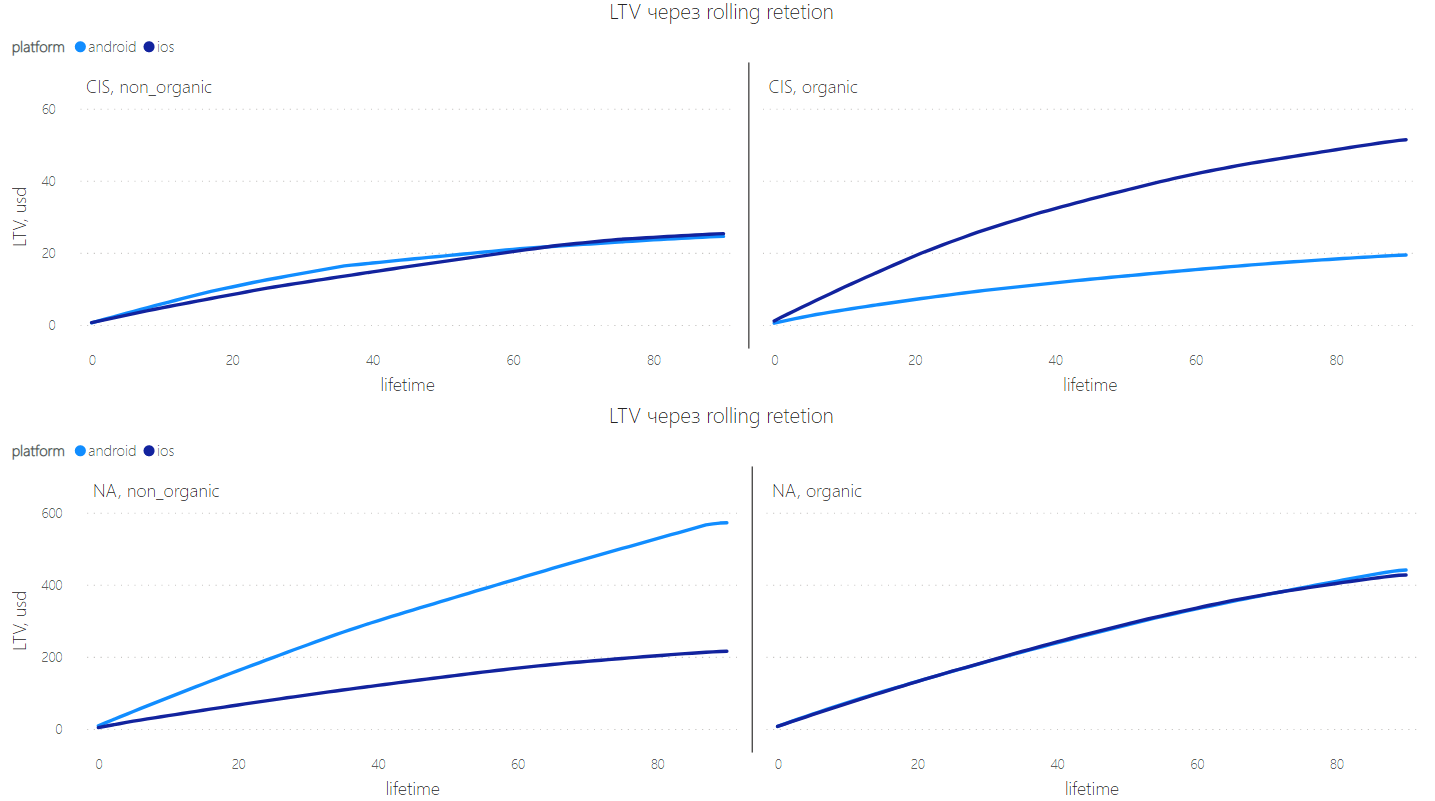

График по динамике роста повторяет предыдущий расчет, но отличается по показателям LTV. Изгибы кривых идентичны, более плавные.

In [4]:
#2 вариант расчета к пункту 3 (без дней после установки), arpdau расчитывалось как среднее от total revenue/dau
pd.read_sql(f'''
with data as

         (SELECT  event_time, user_id, platform, 
            min(event_time) filter (where event_name='FirstLaunchApp') OVER(PARTITION BY user_id) as date_install,
            case WHEN country in ('RU', 'AZ', 'AM', 'BY','KZ', 'KG','MD', 'TJ', 'UZ', 'UA', 'TM') then 'CIS'
                 WHEN country in ('CA', 'US') then 'NA' else 'Other' end as region,
            user_type,revenue_usd

            FROM data_viz_1068.project_dataset
            WHERE user_id in
                    (SELECT user_id
                    FROM data_viz_1068.project_dataset
                    WHERE event_name='FirstLaunchApp')),

    temp_df as(
        SELECT case when user_id>0 then '1' end as  merge,(ROW_NUMBER() OVER())-1 num
        FROM data_viz_1068.project_dataset
        WHERE event_name='FirstLaunchApp'
        LIMIT 91
    )

    
    SELECT  platform, region,user_type, avg(arpdau)*sum(ret_roll) as ltv,sum(ret_roll) as lifetime
    FROM
        (SELECT lifetime, cast(users as float)/cast(max as float) as ret_roll, platform, region,user_type, rev/dau as arpdau
        FROM
            (SELECT num as lifetime, count(distinct user_id) as users,platform, region,user_type,
            max(count(distinct user_id)) over (partition by platform, region,user_type) as max,
            count(distinct user_id) as dau,
            sum(rev) as rev
            FROM
            (SELECT lifetime,num, user_id,platform, region,user_type,rev
            FROM
                    (SELECT *
                    FROM (SELECT max(extract(day from date_trunc('days',event_time-date_install))) as lifetime,
                    user_id, platform, region,user_type, case when user_id>0 then '1' end as  merge, sum(revenue_usd) as  rev
                    FROM data
                    WHERE event_time <=(date_install+INTERVAL '3' MONTH) and region !='Other'
                    GROUP BY 2,3,4,5
                    ORDER BY 1) as l

                    JOIN temp_df  as i
                    ON l.merge=i.merge) as o
            WHERE lifetime>=num 
            ) as f
            GROUP BY 1,3,4,5) as w) as u
    GROUP BY 1,2,3
    


''', con=engine)

,platform,region,user_type,ltv,lifetime
0,android,CIS,non_organic,29.973347,10.790323
1,android,CIS,organic,30.199353,9.235693
2,android,NA,non_organic,903.641529,11.857345
3,android,NA,organic,614.904745,14.809888
4,ios,CIS,non_organic,37.765421,10.779307
5,ios,CIS,organic,76.356678,9.629167
6,ios,NA,non_organic,300.589904,14.518741
7,ios,NA,organic,607.049190,12.322730


Данный расчет отличается от двух предудыщих в выводах.

In [5]:
#расчет к пункту 4 (через накопительный arpdau*lifetime, расчитанный как сумма retention rate на определенный день)
ex4=pd.read_sql(f'''
with all_data as
(    with data as

         (SELECT  event_time, user_id, platform, 
            min(event_time) filter (where event_name='FirstLaunchApp') OVER(PARTITION BY user_id) as date_install,
            case WHEN country in ('RU', 'AZ', 'AM', 'BY','KZ', 'KG','MD', 'TJ', 'UZ', 'UA', 'TM') then 'CIS'
                 WHEN country in ('CA', 'US') then 'NA' else 'Other' end as region,
            user_type,revenue_usd

            FROM data_viz_1068.project_dataset
            WHERE user_id in
                    (SELECT user_id
                    FROM data_viz_1068.project_dataset
                    WHERE event_name='FirstLaunchApp'))
    SELECT lifetime,
        platform, region,user_type,
        cast(users as float)/cast(installs as float) as ret,
        sum(rev) OVER(PARTITION BY platform, region,user_type ORDER BY  lifetime ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS c_rev,
        c_dau
    FROM
        (SELECT lifetime, count(distinct user_id) as users, platform, region,user_type, sum(rev) as rev,
        max(count(distinct user_id)) OVER (PARTITION BY platform, region,user_type) as installs,
        sum(count(distinct user_id)) OVER(PARTITION BY platform, region,user_type ORDER BY  lifetime ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS c_dau
        FROM
            (SELECT max(extract(day from date_trunc('days',event_time-date_install))) as lifetime,
             platform, region,user_type,sum(revenue_usd) as rev, user_id
            FROM data
            GROUP BY 2,3,4,6) as l
        WHERE lifetime between '0' and '90' and region !='Other'
        GROUP BY 1,3,4,5) as q
    ORDER BY 1,2,3,4)

SELECT lifetime,platform, region,user_type,arpdau*sum_ret as ltv
FROM
    (SELECT lifetime, platform, region,user_type, (c_rev/c_dau) as arpdau,
    sum(ret) OVER(PARTITION BY platform, region,user_type ORDER BY  lifetime ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS sum_ret
    FROM all_data) as e

''', con=engine)

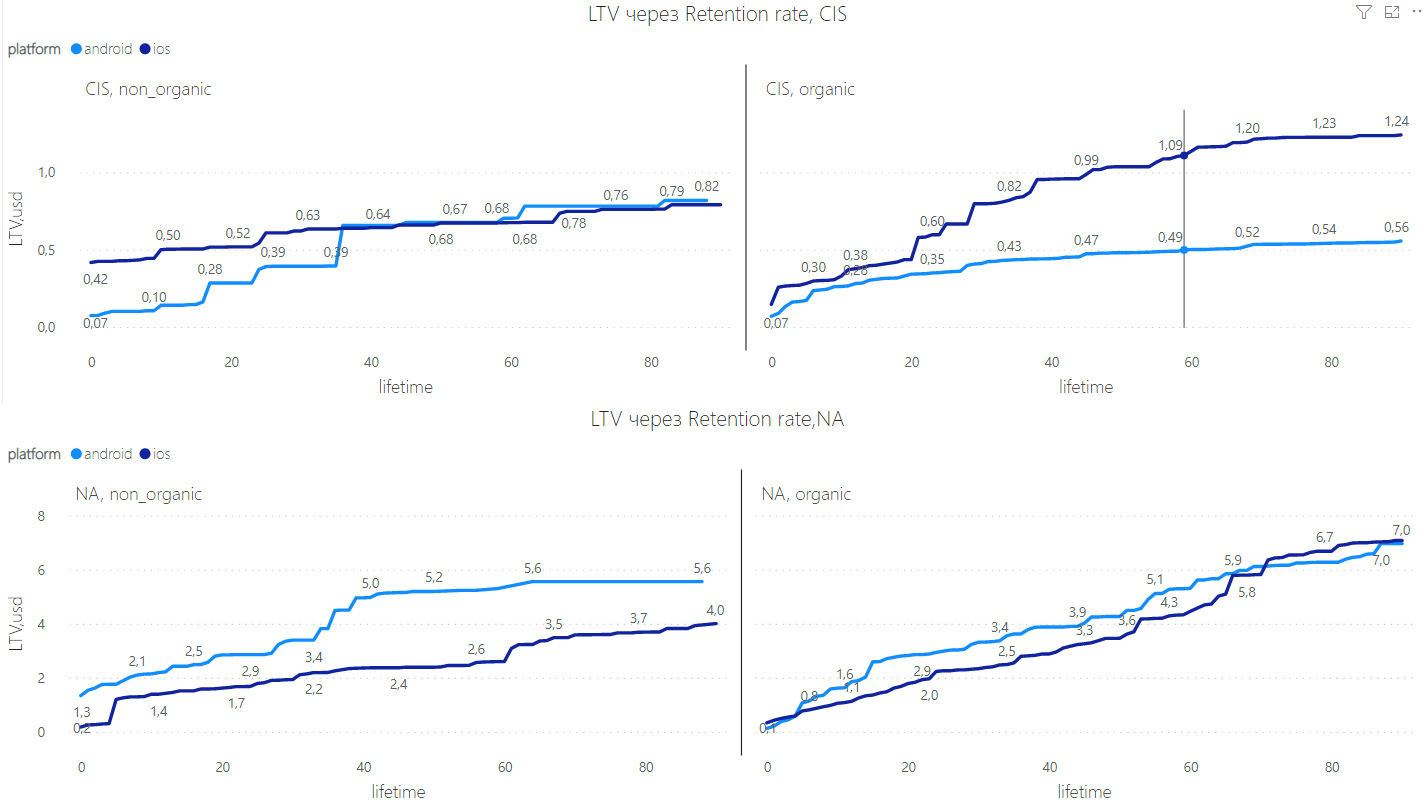

График идентичен первому расчету.

In [6]:
#2 вариант расчета к пункту 4 (через среднее значение arpdau*lifetime как сумма retention rate)
pd.read_sql(f'''
with data as

         (SELECT  event_time, user_id, platform, 
            min(event_time) filter (where event_name='FirstLaunchApp') OVER(PARTITION BY user_id) as date_install,
            case WHEN country in ('RU', 'AZ', 'AM', 'BY','KZ', 'KG','MD', 'TJ', 'UZ', 'UA', 'TM') then 'CIS'
                 WHEN country in ('CA', 'US') then 'NA' else 'Other' end as region,
            user_type,revenue_usd

            FROM data_viz_1068.project_dataset
            WHERE user_id in
                    (SELECT user_id
                    FROM data_viz_1068.project_dataset
                    WHERE event_name='FirstLaunchApp'))
    
    SELECT platform, region,user_type,sum(ret)*avg(rev/users) as ltv,sum(ret) as lifetime
    FROM
    (SELECT platform, region,user_type,
        cast(users as float)/cast(installs as float) as ret,
        rev,users 
    FROM
        (SELECT lifetime, count(distinct user_id) as users, platform, region,user_type, 
        max(count(distinct user_id)) OVER (PARTITION BY platform, region,user_type) as installs,
        sum(rev) as rev
        FROM
            (SELECT max(extract(day from date_trunc('days',event_time-date_install))) as lifetime,
             platform, region,user_type, user_id,sum(revenue_usd) as  rev
            FROM data
            GROUP BY 2,3,4,5) as l
        WHERE lifetime between '0' and '90' and region !='Other'
        GROUP BY 1,3,4,5) as q) as e
    GROUP BY 1,2,3

''', con=engine)

,platform,region,user_type,ltv,lifetime
0,android,CIS,non_organic,2.549306,1.676087
1,android,CIS,organic,1.945472,1.627786
2,android,NA,non_organic,15.041483,1.777188
3,android,NA,organic,23.731594,1.855856
4,ios,CIS,non_organic,1.784539,1.725000
5,ios,CIS,organic,5.498072,1.620250
6,ios,NA,non_organic,21.788432,1.928237
7,ios,NA,organic,47.670629,1.714691


lifetime как сумма retention rate (90 дней) немного странноват в цифрах, слишком маленькие
Расчет также отличается, возможно, допущена ошибка в формулах, именно в том что брался средний arpdau


Общий вывод:
    Как мне показалось, более удобный и быстрый способ расчета среди заданных - через CARPU. Более того, данный метод позволяет видеть динамику показателя с каждым днем жизни пользователя, что дает более четкое представление о проекте.
    Цифры схожи в 1 расчете и в 1ых вариантах остальных расчетов, либо имеют одинаковое процентное соотношение и динамику.
    